DEBUG: Found 10 files in '../logs/sine/sine_*.csv'
DEBUG: Processing 10 unique files...
  [Skip] No header found: sine_20260112-112527.csv

--- BANDWIDTH TEST SUMMARY ---
 frequency  max_error status                     file
       0.5     0.9738   PASS sine_20260112-165716.csv
       1.0     1.1074   PASS sine_20260112-112921.csv
       1.0     1.0336   PASS sine_20260112-163527.csv
       2.0     1.4941   PASS sine_20260112-170225.csv
       2.0     1.4871   PASS sine_20260112-170310.csv
       3.0     1.2516   PASS sine_20260112-170435.csv
       3.0     1.2797   PASS sine_20260112-170517.csv
       3.9     1.1320   PASS sine_20260112-170708.csv
       5.0     0.8859   PASS sine_20260112-170806.csv


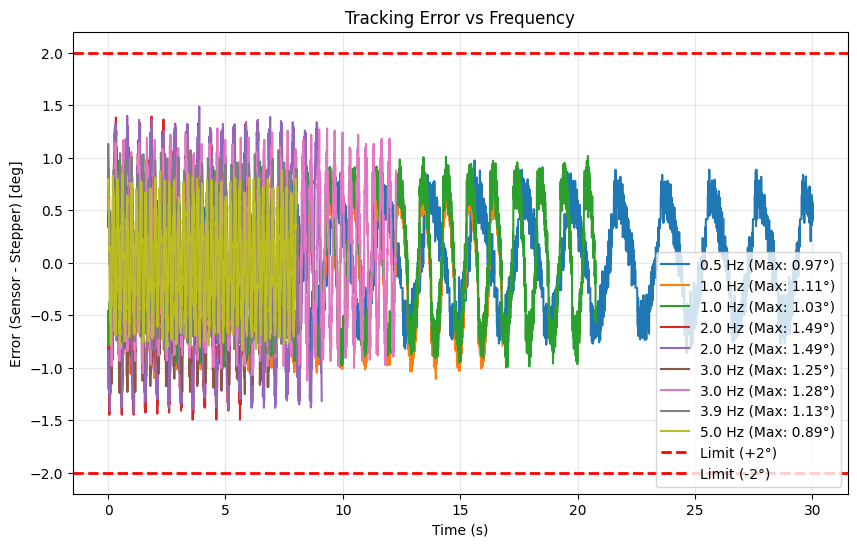

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# --- 1. INTELLIGENT FILE SEARCH ---
# Try multiple paths to find the files relative to the notebook
search_patterns = [
    '../logs/sine/sine_*.csv',   # If notebook is in tools/
    'logs/sine/sine_*.csv',      # If notebook is in root
    'sine_*.csv'                 # If files are in same folder
]

files = []
for pattern in search_patterns:
    found = glob.glob(pattern)
    if found:
        print(f"DEBUG: Found {len(found)} files in '{pattern}'")
        files.extend(found)

# Remove duplicates and sort
files = sorted(list(set(files)))

if not files:
    print("\nERROR: No CSV files found! Check your paths.")
else:
    print(f"DEBUG: Processing {len(files)} unique files...")

    results = []
    limit_deg = 2.0  # Pass/Fail threshold

    # --- 2. ANALYSIS FUNCTION ---
    def analyze_file(filepath):
        # Dynamic header search (skips text block at start)
        header_row = None
        try:
            with open(filepath, 'r') as f:
                lines = f.readlines()
                for i, line in enumerate(lines):
                    if line.strip().startswith('timestamp_ms'):
                        header_row = i
                        break
        except Exception as e:
            print(f"  [Error Reading] {os.path.basename(filepath)}")
            return None

        if header_row is None:
            print(f"  [Skip] No header found: {os.path.basename(filepath)}")
            return None
        
        try:
            # Load Data
            df = pd.read_csv(filepath, header=header_row)
            
            # Clean Data (Force numeric)
            cols = ['timestamp_ms', 'target_deg', 'sensor_deg', 'stepper_deg']
            for c in cols:
                if c not in df.columns: return None
                df[c] = pd.to_numeric(df[c], errors='coerce')
            
            df = df.dropna()
            
            # Skip startup transient (first 1.0s)
            if len(df) > 0:
                t_start = df['timestamp_ms'].iloc[0]
                df = df[df['timestamp_ms'] > (t_start + 1000)]
            
            if len(df) < 50: return None

            # Estimate Frequency (FFT)
            y = df['target_deg'].values
            t = df['timestamp_ms'].values / 1000.0
            dt = np.mean(np.diff(t))
            
            freqs = np.fft.rfftfreq(len(y), dt)
            fft_vals = np.abs(np.fft.rfft(y))
            peak_idx = np.argmax(fft_vals[1:]) + 1 
            est_freq = round(freqs[peak_idx], 1)
            
            # Calculate Error
            error = df['sensor_deg'] - df['stepper_deg']
            max_err = np.max(np.abs(error))
            
            return {
                'file': os.path.basename(filepath),
                'frequency': est_freq,
                'max_error': max_err,
                'status': 'FAIL' if max_err > limit_deg else 'PASS',
                'data': df
            }
        except Exception as e:
            print(f"  [Error Analyzing] {os.path.basename(filepath)}: {e}")
            return None

    # --- 3. RUN ANALYSIS ---
    for f in files:
        res = analyze_file(f)
        if res:
            results.append(res)

    # --- 4. REPORT & PLOT ---
    if not results:
        print("No valid data extracted from files.")
    else:
        results.sort(key=lambda x: x['frequency'])
        
        # Create Summary Table
        summary = pd.DataFrame([{k:v for k,v in r.items() if k != 'data'} for r in results])
        
        print("\n--- BANDWIDTH TEST SUMMARY ---")
        print(summary[['frequency', 'max_error', 'status', 'file']].to_string(index=False))

        # Plot
        plt.figure(figsize=(10, 6))
        for res in results:
            df = res['data']
            t = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0
            err = df['sensor_deg'] - df['stepper_deg']
            plt.plot(t, err, label=f"{res['frequency']} Hz (Max: {res['max_error']:.2f}°)")

        plt.axhline(limit_deg, color='red', linestyle='--', linewidth=2, label='Limit (+2°)')
        plt.axhline(-limit_deg, color='red', linestyle='--', linewidth=2, label='Limit (-2°)')
        plt.title("Tracking Error vs Frequency")
        plt.xlabel("Time (s)")
        plt.ylabel("Error (Sensor - Stepper) [deg]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()